In [1]:
#- Imports e configurações
import warnings
from typing import Dict, Iterable, Optional, Tuple, Sequence

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from kagglehub import KaggleDatasetAdapter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    recall_score,
    make_scorer
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler

warnings.filterwarnings("ignore")

In [2]:
#- Carregar dataset (kagglehub)
file_path = "fetal_health.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "andrewmvd/fetal-health-classification",
    file_path,
)

print("First 5 records:")
display(df.head())

100%|██████████| 223k/223k [00:00<00:00, 7.35MB/s]

First 5 records:


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Basedo no que foi feito durante a EDA as seguintes features foram removidas, pois não seriam muito relevantes para modelagem

In [3]:
# Cell 3 (code) - Remover colunas indesejadas de forma segura
features_f_eliminar = [
    "percentage_of_time_with_abnormal_long_term_variability",
    "mean_value_of_short_term_variability",
]

features_h_eliminar = [
    "histogram_median",
    "histogram_mean",
    "histogram_mode",
    "histogram_number_of_peaks",
    "histogram_number_of_zeroes",
    "histogram_min",
    "histogram_max",
    "histogram_width"
]

to_drop = [c for c in (features_f_eliminar + features_h_eliminar) if c in df.columns]
if to_drop:
    df.drop(columns=to_drop, inplace=True)

print("Columns after drop:", df.columns.tolist())

Columns after drop: ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_long_term_variability', 'histogram_variance', 'histogram_tendency', 'fetal_health']


#Modelage multiclasse

Fazendo uma modelagem multiclasse, analisando por etapa:
- Modelo sem levar em conta o desbalanceamento das classes e sem tunagem
- Modelo com tunagem e levando em conta as classes, tendo como métrica base para o grid search o recall macro
- Modelo com tunagem e levando em conta as classes, tendo como métrica base para o grid search o F2 score

In [4]:
#- Separação treino/val/test e escalonamento
X = df.drop("fetal_health", axis=1)
y = df["fetal_health"]

# 70% train+val, 30% test (estratificado)
x_temp, x_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Dentro de x_temp, separar 20% -> validação (estratificado)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

##Modelagem sem tunagem

In [5]:
#- Modelo base (sem tunagem) e predição
rf = RandomForestClassifier()
rf.fit(x_train_scaled, y_train)
y_pred_base = rf.predict(x_test_scaled)

In [10]:
# Cell 6 (code) - Função de relatório (matriz, report e recall)
def plot_confusion_and_report(y_true, y_pred, labels: Iterable = (1, 2, 3)) -> None:
    """Plota matriz de confusão e imprime classification report + recall macro + F2 macro."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    plt.title("Matriz de Confusão")
    plt.show()

    print(classification_report(y_true, y_pred))
    print("Recall macro:", recall_score(y_true, y_pred, average="macro"))
    f2_macro = fbeta_score(y_true, y_pred, beta=2, average="macro")
    print(f"🎯 F2-score (macro): {f2_macro:.4f}")


=== Resultado do modelo base ===


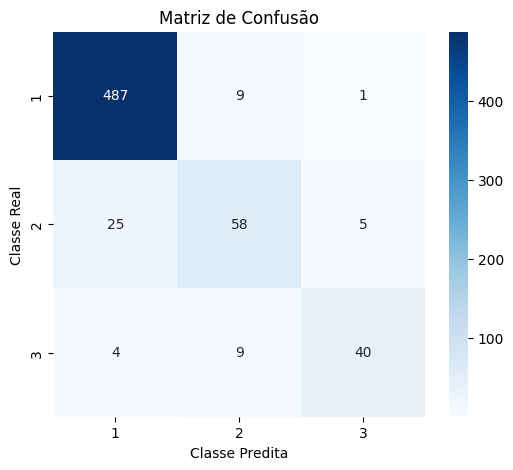

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       497
         2.0       0.76      0.66      0.71        88
         3.0       0.87      0.75      0.81        53

    accuracy                           0.92       638
   macro avg       0.86      0.80      0.83       638
weighted avg       0.91      0.92      0.91       638

Recall macro: 0.7978957219589694
🎯 F2-score (macro): 0.8084


In [8]:
# Avaliar modelo base
print("=== Resultado do modelo base ===")
plot_confusion_and_report(y_test, y_pred_base)

O modelo de **Random Forest baseline**, treinado sem tunagem de hiperparâmetros e sem tratamento do desbalanceamento entre classes, apresentou métricas globais aparentemente satisfatórias, como acurácia de 92%, recall macro de 0,80 e F2-score macro de 0,81; entretanto, esses valores ocultam limitações importantes quando consideradas as **classes de maior relevância clínica**. Os recalls obtidos para as classes **2 (0,66)** e **3 (0,75)** indicam que uma parcela significativa dos casos suspeitos e patológicos não é corretamente identificada, o que é inadequado em um contexto médico, no qual falsos negativos possuem alto custo. Esse comportamento evidencia o viés do modelo em favor da classe majoritária e demonstra que a abordagem baseline **não atende plenamente aos objetivos do projeto**, reforçando a necessidade de **tunagem de hiperparâmetros, estratégias de balanceamento e otimização orientada a métricas sensíveis ao recall** para tornar o modelo mais confiável como apoio à decisão clínica.


##Modelagem com tunagem

In [9]:
#- Grid de parâmetros para tunagem
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"],
}

Funções que serão utilizadas ao longo da modelagem com tunagem para classificação multiclasse

In [4]:
# Cell 8 (code) - Funções auxiliares para tuning e thresholds
def train_grid_search(params: Dict, scoring: str, x_data, y_data, cv: int = 5):
    """Executa GridSearchCV para RandomForest e retorna o objeto GridSearchCV."""
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        params,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
    )
    grid.fit(x_data, y_data)
    return grid


def predict_with_thresholds(proba: np.ndarray, thresholds: Dict[int, float], classes: Iterable) -> np.ndarray:
    """Prediz classes usando thresholds personalizados para as classes 2 e 3."""
    class_idx = {c: i for i, c in enumerate(classes)}
    preds = []
    for p in proba:
        if p[class_idx[3]] >= thresholds.get(3, 0.5):
            preds.append(3)
        elif p[class_idx[2]] >= thresholds.get(2, 0.5):
            preds.append(2)
        else:
            preds.append(1)
    return np.array(preds)


def find_best_thresholds(model, x_val, y_val, classes: Iterable = (1, 2, 3),
                         t2_range: Optional[np.ndarray] = None,
                         t3_range: Optional[np.ndarray] = None):
    """Busca por grid os melhores thresholds (t2, t3) usando F2 macro como métrica."""
    if t2_range is None:
        t2_range = np.linspace(0.1, 0.9, 17)
    if t3_range is None:
        t3_range = np.linspace(0.1, 0.9, 17)

    proba = model.predict_proba(x_val)
    best_score = -1.0
    best_thresholds: Dict[int, float] = {}

    for t2 in t2_range:
        for t3 in t3_range:
            thresholds = {2: t2, 3: t3}
            y_pred = predict_with_thresholds(proba, thresholds, classes)
            score = fbeta_score(y_val, y_pred, beta=2, average="macro")
            if score > best_score:
                best_score = score
                best_thresholds = thresholds.copy()

    return best_thresholds, best_score

Após o teste com o modelo simples, sem a tunagem e sem levar em consideração o desbalanceamento das classes percebe-se que os resultados não são muito satisfatórios, agora iremos gerar modelos que levem em consideração esses dois aspectos

###Base de escolha: Recall

In [11]:
#Cálculo das proporções das classes
pesos = []
ref = y_train.value_counts().max()
for val in y_train.value_counts():
    if(val != ref):
        pesos.append(ref/val)
    else:
        pesos.append(1)
print(pesos)

[1, 5.578313253012048, 9.448979591836734]


Sabendo essa proporção, iremos treinar os modelos com 3 tipos de pesos para as classes:
- 1, 3, 6 => Penalização menor para as classes desbalanceadas
- 1, 4, 8 => Penalização intermediária
- 1, 5, 9 => Penalização mais severa

In [12]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [
        None,
        {1:1, 2:3, 3:6},
        {1:1, 2:4, 3:8},
        {1:1, 2:5, 3:9}
    ]
}


Iniciando GridSearch (scoring='recall_macro')...
🏆 Melhores parâmetros (recall_macro):
  class_weight: {1: 1, 2: 5, 3: 9}
  criterion: entropy
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 5
  min_samples_split: 2
  n_estimators: 200
=== Resultado pós-tunagem ===


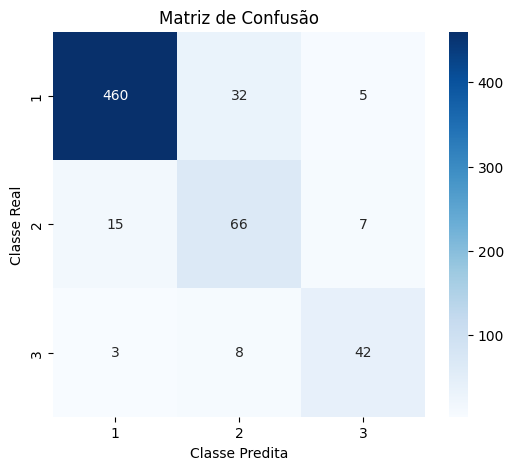

              precision    recall  f1-score   support

         1.0       0.96      0.93      0.94       497
         2.0       0.62      0.75      0.68        88
         3.0       0.78      0.79      0.79        53

    accuracy                           0.89       638
   macro avg       0.79      0.82      0.80       638
weighted avg       0.90      0.89      0.89       638

Recall macro: 0.822668716702732
🎯 F2-score (macro): 0.8142
Melhores thresholds encontrados: {2: np.float64(0.35), 3: np.float64(0.5)} com F2: 0.8918229837875679
=== Resultado com thresholds ajustados ===


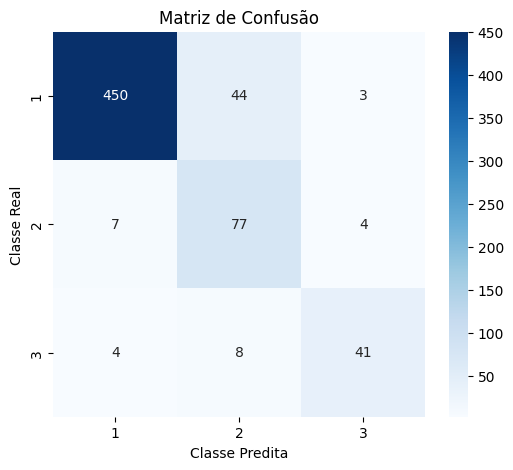

              precision    recall  f1-score   support

         1.0       0.98      0.91      0.94       497
         2.0       0.60      0.88      0.71        88
         3.0       0.85      0.77      0.81        53

    accuracy                           0.89       638
   macro avg       0.81      0.85      0.82       638
weighted avg       0.91      0.89      0.90       638

Recall macro: 0.8513391670779393
🎯 F2-score (macro): 0.8359


In [13]:
#- GridSearch (scoring por recall_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='recall_macro')...")
grid_search_rec = train_grid_search(param_grid, "recall_macro", x_train_scaled, y_train)
print("🏆 Melhores parâmetros (recall_macro):")
for param, value in grid_search_rec.best_params_.items():
    print(f"  {param}: {value}")

rf_rec = grid_search_rec.best_estimator_
rf_rec.fit(x_train_scaled, y_train)

# Avaliação no teste
y_pred_rec = rf_rec.predict(x_test_scaled)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test, y_pred_rec)

# Busca de thresholds na validação
best_thr, best_score = find_best_thresholds(rf_rec, x_val_scaled, y_val)
print("Melhores thresholds encontrados:", best_thr, "com F2:", best_score)

# Avaliar no teste com thresholds ajustados
proba_test = rf_rec.predict_proba(x_test_scaled)
y_pred_thresh = predict_with_thresholds(proba_test, best_thr, classes=rf_rec.classes_)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test, y_pred_thresh)

###Base de escolha do modelo: F2 score + pesos

In [13]:
#- Gerando a métrica F2 score para poder ser utilizada no grid search que é feito
f2_macro = make_scorer(
    fbeta_score,
    beta=2,
    average='macro'
)

Iniciando GridSearch (scoring='f2_macro')...
🏆 Melhores parâmetros (f2_macro):
  class_weight: {1: 1, 2: 3, 3: 6}
  criterion: gini
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 200
=== Resultado pós-tunagem ===


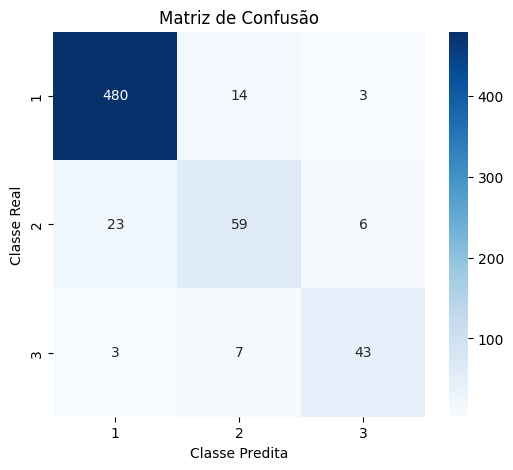

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       497
         2.0       0.74      0.67      0.70        88
         3.0       0.83      0.81      0.82        53

    accuracy                           0.91       638
   macro avg       0.84      0.82      0.83       638
weighted avg       0.91      0.91      0.91       638

Recall macro: 0.8158566895943989
🎯 F2-score (macro): 0.8199
Melhores thresholds encontrados: {2: np.float64(0.25), 3: np.float64(0.45000000000000007)} com F2: 0.9166656377599484
=== Resultado com thresholds ajustados ===


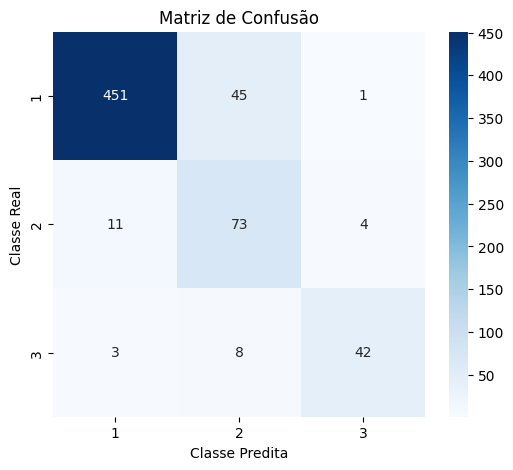

              precision    recall  f1-score   support

         1.0       0.97      0.91      0.94       497
         2.0       0.58      0.83      0.68        88
         3.0       0.89      0.79      0.84        53

    accuracy                           0.89       638
   macro avg       0.81      0.84      0.82       638
weighted avg       0.91      0.89      0.89       638

Recall macro: 0.8431476509140609
🎯 F2-score (macro): 0.8312


In [20]:
#- GridSearch (scoring por f2_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='f2_macro')...")
grid_search_f2 = train_grid_search(param_grid, f2_macro, x_train_scaled, y_train)
print("🏆 Melhores parâmetros (f2_macro):")
for param, value in grid_search_f2.best_params_.items():
    print(f"  {param}: {value}")

rf_f2 = grid_search_f2.best_estimator_
rf_f2.fit(x_train_scaled, y_train)

# Avaliação no teste
y_pred_f2 = rf_f2.predict(x_test_scaled)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test, y_pred_f2)

# Busca de thresholds na validação
best_thr_f2, best_score_f2 = find_best_thresholds(rf_f2, x_val_scaled, y_val)
print("Melhores thresholds encontrados:", best_thr_f2, "com F2:", best_score_f2)

# Avaliar no teste com thresholds ajustados
proba_test_f2 = rf_f2.predict_proba(x_test_scaled)
y_pred_thresh_f2 = predict_with_thresholds(proba_test_f2, best_thr_f2, classes=rf_f2.classes_)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test, y_pred_thresh_f2)

A comparação entre as duas estratégias de tunagem evidencia que o **GridSearch orientado pelo recall macro** produziu o modelo mais alinhado aos objetivos do projeto. Apesar de ambos os modelos apresentarem métricas globais semelhantes, a otimização por recall macro resultou em **maior sensibilidade para as classes críticas**, especialmente para a classe **2**, que alcançou **recall de 0,88**, em comparação a **0,83** no modelo otimizado por F2-score. Esse comportamento é corroborado pelo **recall macro superior (0,85 vs. 0,84)** e pelo **F2-score macro ligeiramente maior (0,84 vs. 0,83)**. Considerando que o principal objetivo do projeto é minimizar falsos negativos em classes de risco, a tunagem baseada em recall macro mostrou-se mais adequada, reforçando sua escolha como critério principal de otimização do modelo.


##Feature importance

Analisando quais features foram mais importantes para o modelo baseado no melhor modelo que foi o que teve como base de escolha f2_score

In [21]:
# Feature importance
feature_names = X.columns
importances = rf_rec.feature_importances_
indices = np.argsort(importances)[::-1]

In [22]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  abnormal_short_term_variability: 0.242
  mean_value_of_long_term_variability: 0.128
  accelerations: 0.126
  baseline value: 0.122
  histogram_variance: 0.121


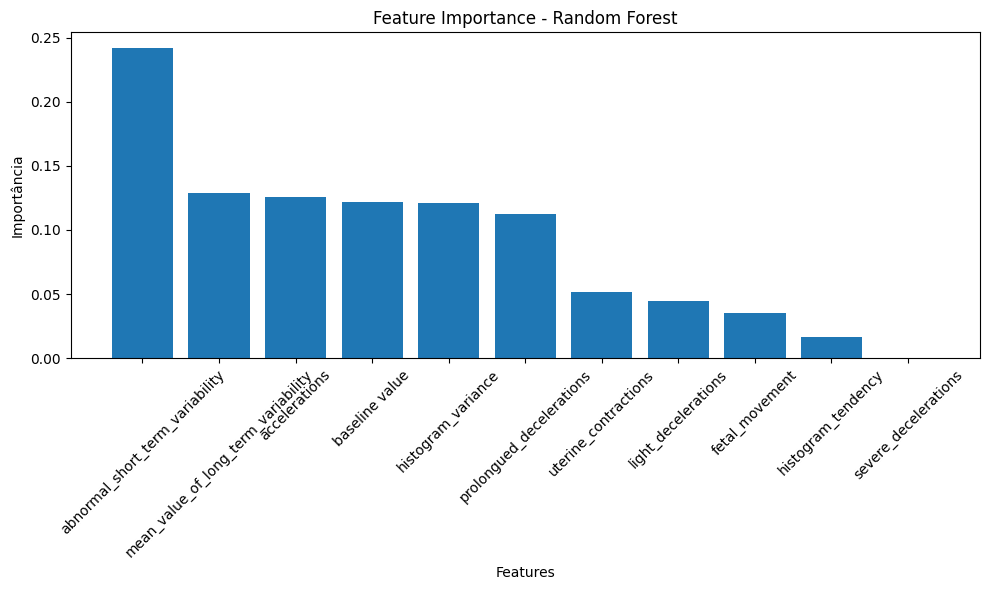

In [23]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Random Forest')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

#Modelage binária

In [8]:
# Cell 4 (code) - Separação treino/val/test e escalonamento
X = df.drop("fetal_health", axis=1)
y = df["fetal_health"]

#Fazer com que a classe 3 tenha o mesmo valor que a classe 2
y = y.replace(3, 2)

# 70% train+val, 30% test (estratificado)
x_temp, x_test_bin, y_temp, y_test_bin = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Dentro de x_temp, separar 20% -> validação (estratificado)
x_train_bin, x_val_bin, y_train_bin, y_val_bin = train_test_split(
    x_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

scaler = RobustScaler()
x_train_scaled_bin = scaler.fit_transform(x_train_bin)
x_val_scaled_bin = scaler.transform(x_val_bin)
x_test_scaled_bin = scaler.transform(x_test_bin)

##Modelagem sem tunagem

=== Resultado do modelo base ===


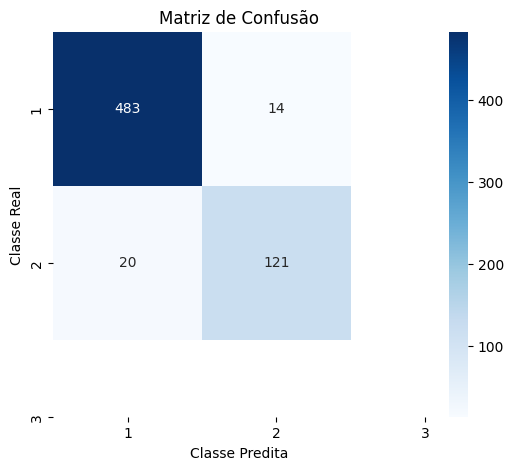

              precision    recall  f1-score   support

         1.0       0.96      0.97      0.97       497
         2.0       0.90      0.86      0.88       141

    accuracy                           0.95       638
   macro avg       0.93      0.91      0.92       638
weighted avg       0.95      0.95      0.95       638

Recall macro: 0.9149935071421437
🎯 F2-score (macro): 0.9175


In [30]:
#- Modelo base (sem tunagem) e predição
rf_bin = RandomForestClassifier()
rf_bin.fit(x_train_scaled_bin, y_train_bin)
y_pred_base_bin = rf_bin.predict(x_test_scaled_bin)

# Avaliar modelo base
print("=== Resultado do modelo base ===")
plot_confusion_and_report(y_test_bin, y_pred_base_bin)

No cenário de **classificação binária**, o modelo de **Random Forest sem tunagem** apresentou melhora significativa nas métricas de interesse, com **recall macro de 0,91** e **F2-score macro de 0,92**, indicando maior sensibilidade na identificação da classe positiva em comparação ao cenário multiclasse. Esse comportamento é esperado, uma vez que a reformulação do problema reduz a complexidade da tarefa de classificação; contudo, os resultados ainda refletem as limitações de um modelo treinado sem otimização específica. A ausência de tunagem e de estratégias direcionadas ao desbalanceamento pode comprometer a robustez do modelo em cenários mais críticos, reforçando que, apesar do desempenho inicial promissor, essa abordagem deve ser interpretada como um **baseline** e não como uma solução final adequada ao objetivo de apoio à decisão clínica.


##Modelagem com tunagem

In [31]:
ref = y_train_bin.value_counts().max()
for val in y_train_bin.value_counts():
    if(val != ref):
        print(ref/val)

3.507575757575758


Fazendo a modelagem sem tunagem, percebe-se que os resultados não foram ruins, porém tentaremos melhorar usando a tunagem mais o uso de pesos para as classes:
- 1, 2 => Penalização suave
- 1, 4 => Penalização intermediária
- 1, 5 => Penalização severa

In [5]:
param_grid_bin = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [
        None,
        {1:1, 2:2},
        {1:1, 2:4},
        {1:1, 2:5}
    ]
}

Fazendo um grid search tendo como critério de decisão a acurácia

In [6]:

def predict_binary_with_threshold(
    proba: np.ndarray,
    threshold: float,
    classes: Sequence[int],
    positive_class: int,
) -> np.ndarray:
    """Prediz rótulos binários a partir de probabilidades aplicando um threshold.

    Args:
        proba: Matriz de probabilidades com forma (n_samples, n_classes).
        threshold: Threshold para a classe positiva.
        classes: Sequência com os rótulos das classes (ex.: [0, 1] ou [1, 2]).
        positive_class: Rótulo da classe considerada positiva.

    Returns:
        Array de previsões com os rótulos correspondentes (positive_class ou negative_class).
    """
    class_idx = {c: i for i, c in enumerate(classes)}
    if positive_class not in class_idx:
        raise ValueError("positive_class must be present in classes")

    pos_idx = class_idx[positive_class]

    negative_candidates = [c for c in classes if c != positive_class]
    if not negative_candidates:
        raise ValueError("classes must contain at least one negative class")
    negative_class = negative_candidates[0]

    preds = []
    for p in proba:
        if p[pos_idx] >= threshold:
            preds.append(positive_class)
        else:
            preds.append(negative_class)

    return np.array(preds)


def find_best_threshold_binary(
    model,
    x_val: np.ndarray,
    y_val: np.ndarray,
    classes: Sequence[int],
    positive_class: int,
    t_range: Optional[np.ndarray] = None,
) -> Tuple[float, float]:
    """Encontra o melhor threshold para classificação binária maximizando F2.

    Args:
        model: Modelo com método predict_proba.
        x_val: Dados de validação (features).
        y_val: Rótulos de validação.
        classes: Sequência com os rótulos das classes (ex.: [0, 1] ou [1, 2]).
        positive_class: Rótulo da classe positiva para a métrica.
        t_range: Opcional array de thresholds a testar. Se None, usa np.linspace(0.05, 0.95, 37).

    Returns:
        Tupla (best_threshold, best_score) onde best_score é o F2 (beta=2) correspondente.
    """
    if t_range is None:
        t_range = np.linspace(0.05, 0.95, 37)

    proba = model.predict_proba(x_val)

    best_score = -1.0
    best_threshold = 0.5

    for t in t_range:
        y_pred = predict_binary_with_threshold(
            proba=proba,
            threshold=float(t),
            classes=classes,
            positive_class=positive_class,
        )

        score = fbeta_score(
            y_val,
            y_pred,
            beta=2,
            average="binary",
            pos_label=positive_class,
        )

        if score > best_score:
            best_score = float(score)
            best_threshold = float(t)

    return best_threshold, best_score

###Base de escolha: Recall macro + pesos

Iniciando GridSearch (scoring='recall_macro')...
🏆 Melhores parâmetros (recall_macro):
  class_weight: None
  criterion: gini
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100
=== Resultado pós-tunagem ===


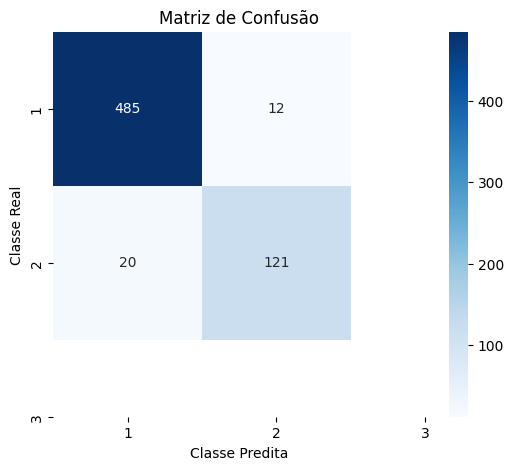

              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       497
         2.0       0.91      0.86      0.88       141

    accuracy                           0.95       638
   macro avg       0.94      0.92      0.93       638
weighted avg       0.95      0.95      0.95       638

Recall macro: 0.9170055795767513
🎯 F2-score (macro): 0.9204
Melhores thresholds encontrados: 0.175 com F2: 0.8873239436619719
=== Resultado com thresholds ajustados ===


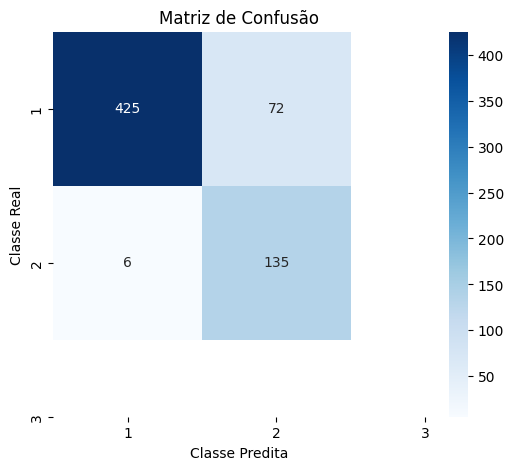

              precision    recall  f1-score   support

         1.0       0.99      0.86      0.92       497
         2.0       0.65      0.96      0.78       141

    accuracy                           0.88       638
   macro avg       0.82      0.91      0.85       638
weighted avg       0.91      0.88      0.88       638

Recall macro: 0.906288796609444
🎯 F2-score (macro): 0.8770


In [11]:
# Cell 9 (code) - GridSearch (scoring por recall_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='recall_macro')...")
grid_search_rec_bin = train_grid_search(param_grid_bin, "recall_macro", x_train_scaled_bin, y_train_bin)
print("🏆 Melhores parâmetros (recall_macro):")
for param, value in grid_search_rec_bin.best_params_.items():
    print(f"  {param}: {value}")

rf_rec_bin = grid_search_rec_bin.best_estimator_
rf_rec_bin.fit(x_train_scaled_bin, y_train_bin)

# Avaliação no teste
y_pred_rec_bin = rf_rec_bin.predict(x_test_scaled_bin)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test_bin, y_pred_rec_bin)

# Busca de thresholds na validação
best_thr_bin, best_score_bin = find_best_threshold_binary(rf_rec_bin, x_val_scaled_bin, y_val_bin, classes=rf_rec_bin.classes_, positive_class=2)
print("Melhores thresholds encontrados:", best_thr_bin, "com F2:", best_score_bin)

# Avaliar no teste com thresholds ajustados
proba_test_bin = rf_rec_bin.predict_proba(x_test_scaled_bin)
y_pred_thresh = predict_binary_with_threshold(proba_test_bin, best_thr_bin, classes=rf_rec_bin.classes_, positive_class=2)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test_bin, y_pred_thresh)


###Base de escolha do modelo: F2 score + pesos

Iniciando GridSearch (scoring='f2_macro')...
🏆 Melhores parâmetros (f2_macro):
  class_weight: None
  criterion: gini
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100
=== Resultado pós-tunagem ===


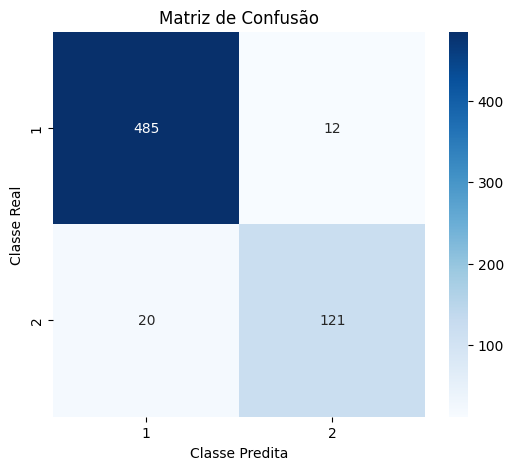

              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       497
         2.0       0.91      0.86      0.88       141

    accuracy                           0.95       638
   macro avg       0.94      0.92      0.93       638
weighted avg       0.95      0.95      0.95       638

Recall macro: 0.9170055795767513
🎯 F2-score (macro): 0.9204
Melhores thresholds encontrados: 0.175 com F2: 0.8873239436619719
=== Resultado com thresholds ajustados ===


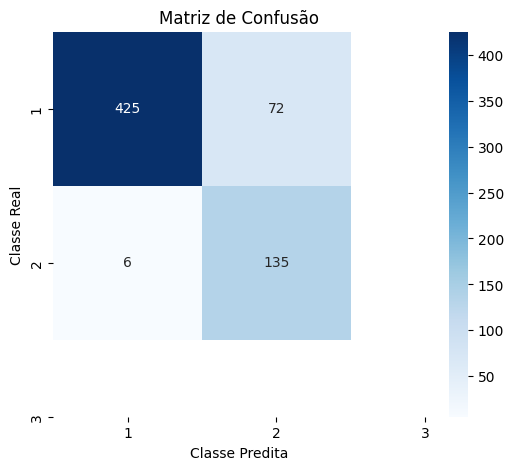

              precision    recall  f1-score   support

         1.0       0.99      0.86      0.92       497
         2.0       0.65      0.96      0.78       141

    accuracy                           0.88       638
   macro avg       0.82      0.91      0.85       638
weighted avg       0.91      0.88      0.88       638

Recall macro: 0.906288796609444
🎯 F2-score (macro): 0.8770


In [15]:
# Cell 9 (code) - GridSearch (scoring por f2_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='f2_macro')...")
grid_search_f2_bin = train_grid_search(param_grid_bin, f2_macro, x_train_scaled_bin, y_train_bin)
print("🏆 Melhores parâmetros (f2_macro):")
for param, value in grid_search_f2_bin.best_params_.items():
    print(f"  {param}: {value}")

rf_f2_bin = grid_search_f2_bin.best_estimator_
rf_f2_bin.fit(x_train_scaled_bin, y_train_bin)

# Avaliação no teste
y_pred_f2_bin = rf_f2_bin.predict(x_test_scaled_bin)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test_bin, y_pred_f2_bin, labels=(1, 2))

# Busca de thresholds na validação
best_thr_f2_bin, best_score_f2_bin = find_best_threshold_binary(rf_f2_bin, x_val_scaled_bin, y_val_bin, classes=rf_f2_bin.classes_, positive_class=2)
print("Melhores thresholds encontrados:", best_thr_f2_bin, "com F2:", best_score_f2_bin)

# Avaliar no teste com thresholds ajustados
proba_test_f2_bin = rf_f2_bin.predict_proba(x_test_scaled_bin)
y_pred_f2_thresh = predict_binary_with_threshold(proba_test_f2_bin, best_thr_f2_bin, classes=rf_f2_bin.classes_, positive_class=2)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test_bin, y_pred_f2_thresh)


No cenário de **classificação binária com tunagem**, os resultados obtidos a partir do **GridSearch orientado por recall macro** e por **F2-score** foram idênticos, indicando convergência das duas métricas para a mesma solução ótima. O modelo alcançou **recall elevado para a classe positiva (0,96)**, refletindo alta sensibilidade na detecção dos casos de risco, ao custo de redução na precisão, comportamento esperado e aceitável no contexto médico. Essa convergência ocorre porque, em um problema binário com classes desbalanceadas, o **F2-score é fortemente influenciado pelo recall**, fazendo com que a otimização por ambas as métricas privilegie o mesmo conjunto de hiperparâmetros. Assim, o resultado reforça que a tunagem adotada está alinhada ao objetivo central do projeto de **minimizar falsos negativos**, validando a escolha das métricas utilizadas na otimização do modelo.


##Feature Importance

Analisando quais features foram mais importantes para o modelo

In [16]:
# Feature importance
feature_names = X.columns
importances = rf_rec_bin.feature_importances_
indices = np.argsort(importances)[::-1]

In [17]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  abnormal_short_term_variability: 0.291
  accelerations: 0.129
  uterine_contractions: 0.114
  baseline value: 0.099
  histogram_variance: 0.098


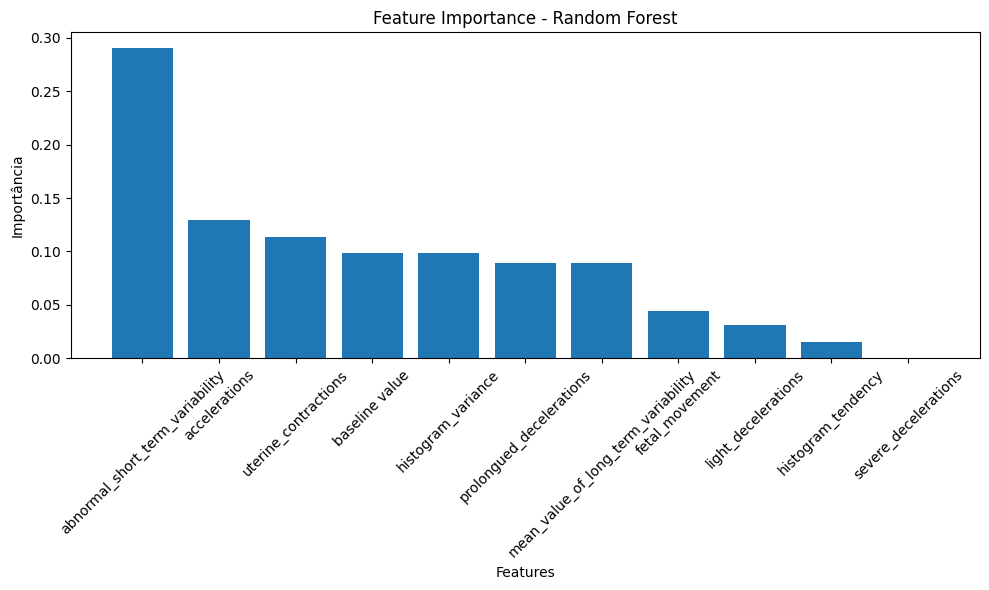

In [18]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Random Forest')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()